In [49]:
import importlib
import fm_models
importlib.reload(fm_models)
from signal_gen import RFSignalDataset
from fm_models import RFSignalDiT
from utils import get_classifier_model
from config import CONFIG, DEVICE
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

fm_model = RFSignalDiT().to(DEVICE)
fm_model.load_state_dict(torch.load("/root/code/flow_matching/checkpoints/01-19--11-23/model_final.pth", map_location=DEVICE))
classifier_model = get_classifier_model().to(DEVICE)
classifier_model.load_state_dict(torch.load('/root/code/flow_matching/checkpoints/01-19--15-11/classifier_final.pth', map_location=DEVICE))
#========
classifier_model_ft = get_classifier_model().to(DEVICE)
classifier_model_ft.load_state_dict(torch.load('/root/code/flow_matching/checkpoints/01-19--20-11/classifier_finetuned_final.pth', map_location=DEVICE))

<All keys matched successfully>

In [ ]:
# --- 配置评估参数 ---
# SNR 扫描范围：从 -10dB 到 x dB
snr_range = np.arange(-10, 0+1, 1) 

# 每个 SNR 点评估的 batch 数量 (求平均以获得稳定结果)
batch_size = 50 * CONFIG["num_classes"] # num per class * num_classes in each SNR
torch.manual_seed(100)
np.random.seed(100)
# 准备一个"干净"的数据集源，用于在评估时手动添加指定 SNR 的噪声
# 这样我们可以严格控制评估时的 SNR 和 t 的对应关系
clean_dataset = RFSignalDataset(num_samples=int(1e5), snr_range=None)
clean_loader = DataLoader(clean_dataset, batch_size=batch_size)
iter_clean_loader = iter(clean_loader)

In [39]:
def add_awgn(sig, snr_db):
    """在信号上添加指定 SNR 的高斯白噪声，并重新归一化功率"""
    # 假设输入信号 sig 已经功率归一化 (Ps = 1)
    # SNR = 10 * log10(Ps / Pn)  =>  Pn = Ps / 10^(SNR/10)
    power_noise = 1.0 / (10**(snr_db / 10.0))
    
    # 对于复数信号，总噪声功率由 I 和 Q 共同贡献
    # Pn = Var(I) + Var(Q) = sigma^2 + sigma^2 = 2 * sigma^2
    # 因此每个分量的方差应为 Pn / 2
    noise_std = torch.sqrt(torch.tensor(power_noise / 2.0, device=sig.device))
    
    # randn_like 生成标准正态分布 (mean=0, std=1)
    noise = torch.randn_like(sig) * noise_std
    noisy_sig = sig + noise

    # 重新归一化功率
    energy = torch.sum(noisy_sig**2, dim=(1, 2), keepdim=True)
    length = noisy_sig.shape[2] # L
    power_noisy = energy / length
    
    noisy_sig = noisy_sig / torch.sqrt(power_noisy + 1e-8)

    return noisy_sig

def snr2t(snr_db):
    """根据 SNR 计算扩散时间步 t"""
    R = 10 ** (snr_db / 20.0)
    t = R / (1+R)
    return t

In [50]:
# --- 执行评估循环 ---
from tqdm import tqdm
acc_noisy_list = [0] * len(snr_range)
acc_denoised_list = [0] * len(snr_range)
acc_clean_list = [0] * len(snr_range)
confusion_data = {
    -10: {'clean': [], 'noisy': [], 'denoised': [], 'label': []},
    -5:  {'clean': [], 'noisy': [], 'denoised': [], 'label': []},
    0: {'clean': [], 'noisy': [], 'denoised': [], 'label': []}
}

# 使用 no_grad context 避免梯度计算占用显存
with torch.no_grad():
    for idx, snr in tqdm(enumerate(snr_range),total=len(snr_range)):
        sig, label, _ = next(iter_clean_loader)
        noisy_sig = add_awgn(sig, snr_db=snr)
        sig, label = sig.to(DEVICE), label.to(DEVICE)
        noisy_sig = noisy_sig.to(DEVICE)
        N = sig.shape[0]
        
        # Eval clean sig
        logits = classifier_model(sig)
        preds = torch.argmax(logits, dim=1)
        correct = (label == preds).sum().item()
        acc_clean_list[idx] = correct / N

        # Eval noisy sig (Directly to classifier)
        logits_noisy = classifier_model(noisy_sig)
        preds_noisy = torch.argmax(logits_noisy, dim=1)
        correct_noisy = (label == preds_noisy).sum().item()
        acc_noisy_list[idx] = correct_noisy / N

        # Eval Denoised sig (Through FM)
        t = snr2t(snr)
        scale_factor = torch.sqrt(torch.tensor((1 - t)**2 + t**2, device=noisy_sig.device))
        # 进行去噪推理
        step = int((1-t)/1.0 * 300) #TODO: more steps for better quality
        sig_denoised = fm_model.predict_x1(noisy_sig * scale_factor, t_start=t, steps=step)
        logits_denoised = classifier_model_ft(sig_denoised)
        preds_denoised = torch.argmax(logits_denoised, dim=1)
        correct_denoised = (label == preds_denoised).sum().item()
        acc_denoised_list[idx] = correct_denoised / N
        
        if snr in confusion_data:
            # 收集预测结果 
            confusion_data[snr]['clean'].append(preds.cpu().numpy())
            confusion_data[snr]['noisy'].append(preds_noisy.cpu().numpy())
            confusion_data[snr]['denoised'].append(preds_denoised.cpu().numpy())
            confusion_data[snr]['label'].append(label.cpu().numpy())

100%|██████████| 11/11 [05:13<00:00, 28.48s/it]


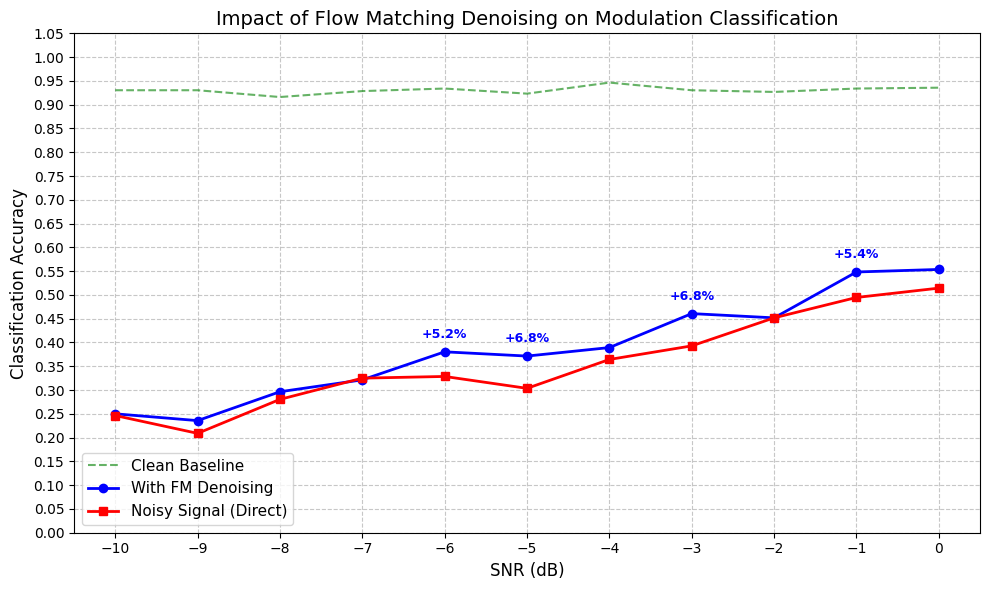

In [51]:
# --- 绘制评估结果曲线 ---
plt.figure(figsize=(10, 6), dpi=100)

# 1. 绘制 Upper Bound (Clean Signal)
# 注意：acc_clean_list 在每个 SNR 循环里都计算了一次，理论上应该是差不多的（只是因为每次采样batch不同会有微小波动）
plt.plot(snr_range, acc_clean_list, 'g--', linewidth=1.5, alpha=0.6, label=f'Clean Baseline ')

# 2. 绘制 Flow Matching Denoised 结果
plt.plot(snr_range, acc_denoised_list, 'b-o', linewidth=2, label='With FM Denoising')

# 3. 绘制 Lower Bound (Noisy Signal)
plt.plot(snr_range, acc_noisy_list, 'r-s', linewidth=2, label='Noisy Signal (Direct)')

plt.xlabel("SNR (dB)", fontsize=12)
plt.ylabel("Classification Accuracy", fontsize=12)
plt.title("Impact of Flow Matching Denoising on Modulation Classification", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=11)
plt.xticks(snr_range)
plt.ylim(0, 1.05)  # Accuracy is 0-1
plt.yticks(np.arange(0, 1.1, 0.05)) # 设置 y 轴刻度间隔为 0.1

# 标注提升幅度
for i, snr in enumerate(snr_range):
    # 计算提升百分比
    gain = acc_denoised_list[i] - acc_noisy_list[i]
    if gain > 0.05: # 只标注提升超过 5% 的点，避免图表太乱
        plt.annotate(f"+{gain*100:.1f}%", 
                     (snr, acc_denoised_list[i]), 
                     textcoords="offset points", 
                     xytext=(0, 10), 
                     ha='center',
                     color='blue',
                     fontweight='bold',
                     fontsize=9)

plt.tight_layout()
plt.show()

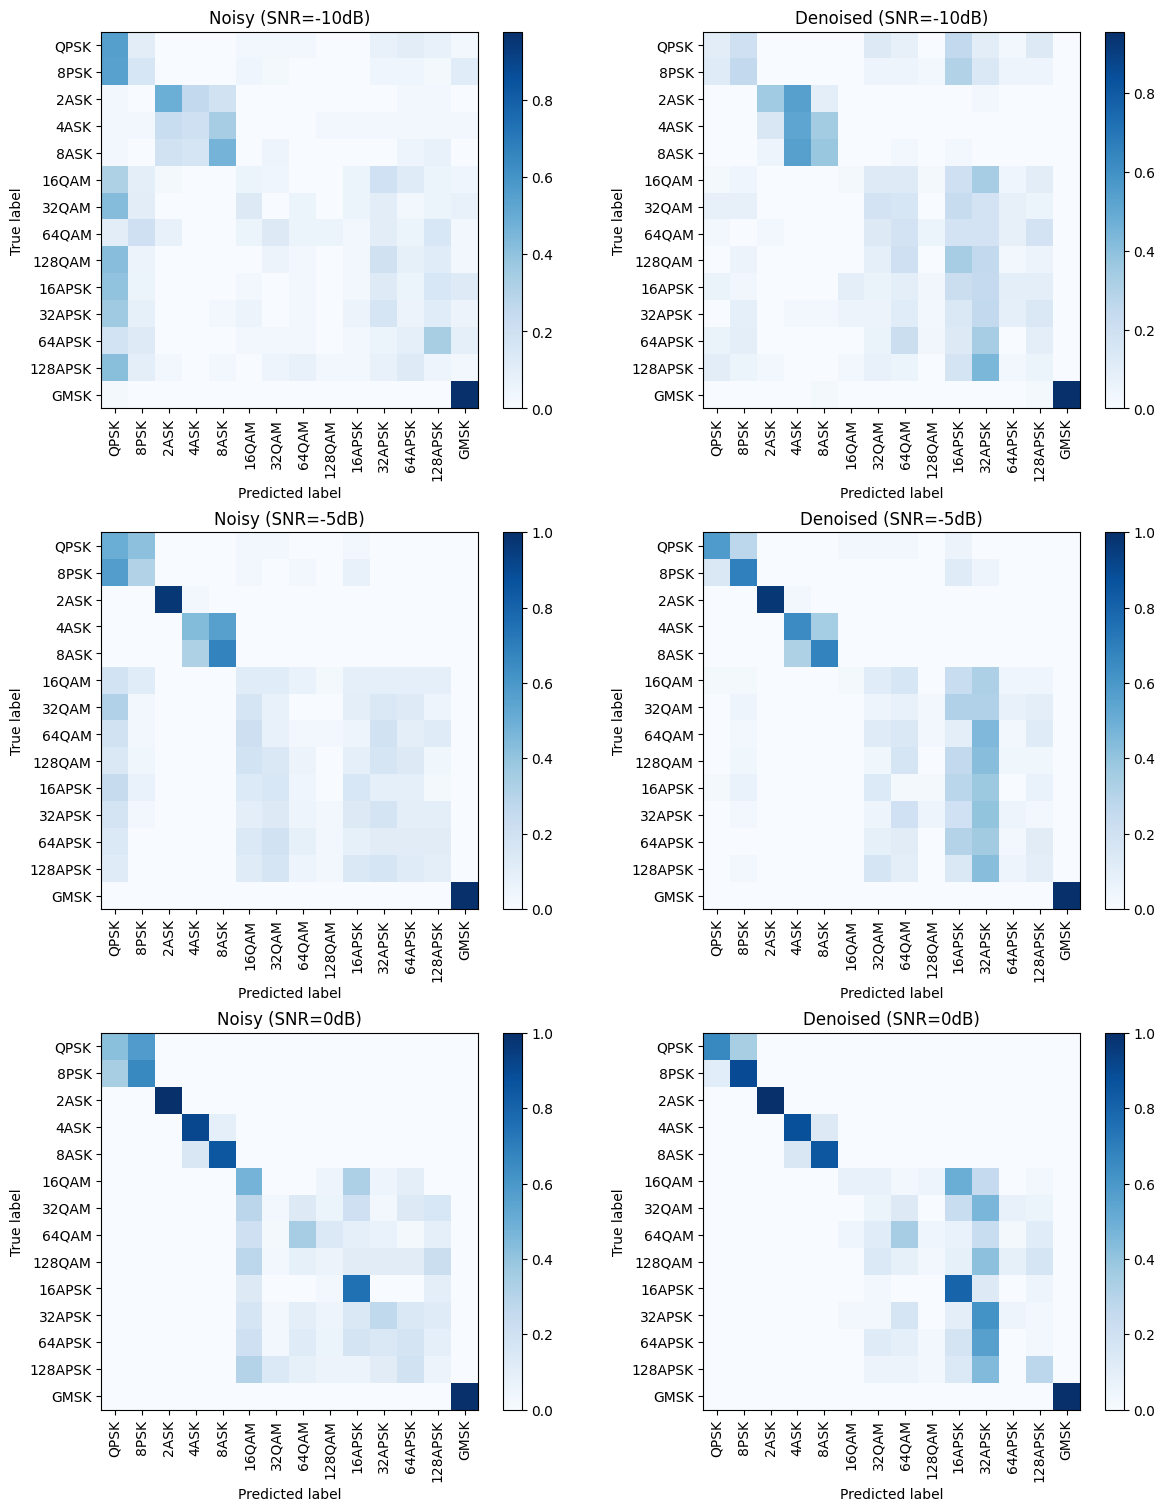

In [52]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

snrs = sorted(confusion_data.keys())
# squeeze=False 保证 axes 始终是 2D 数组，避免 1 行时的 shape 问题
# 修改列数为2，只显示 Noisy 和 Denoised
fig, axes = plt.subplots(len(snrs), 2, figsize=(12, 5 * len(snrs)), constrained_layout=True, squeeze=False)
class_names = clean_dataset.mod_types

for i, snr in enumerate(snrs):
    # 拼接当前 SNR 下的所有 batch 数据
    y_true = np.concatenate(confusion_data[snr]['label'])
    scenarios = [
        # 去掉 Clean，只保留 Noisy 和 Denoised
        ('Noisy',    np.concatenate(confusion_data[snr]['noisy']),    'Blues'),
        ('Denoised', np.concatenate(confusion_data[snr]['denoised']), 'Blues')
    ]
    
    for j, (title, y_pred, cmap) in enumerate(scenarios):
        cm = confusion_matrix(y_true, y_pred, normalize='true')
        disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
        # vmin/vmax=0/1 确保热力图颜色范围一致
        disp.plot(ax=axes[i, j], cmap=cmap, include_values=False, xticks_rotation=90)
        axes[i, j].set_title(f"{title} (SNR={snr}dB)")

plt.show()